In [540]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.express as px # for visualization 
import plotly.graph_objs as go 
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.io as pio
pyo.init_notebook_mode(connected = True)
pio.renderers.default = "png"

import os
import zipfile
import HelperFunctions as hf

sns.set_palette('Set2')


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days

## Content

[Data Structure](#2.-Data-Structure)
- [Calendar](#2.1-Calendar)
- [Sale](#2.2-Sales)
- [Sell Price](#2.3-Sell-Prices)
- [Summary](#Summary)


[Combine Data](#3.-Combine-Data)

- Information of Variable



[By Item](#4.-By-item)
 - [Average sales between items](#4.1-Average-Sales-between-items)

 - [Distribution-of-total-sales-by-category](#4.2-Distribution-of-total-sales-by-category)
 
 - [Distribution-of-average-weekday--sales-by-category](#4.4-Distribution-of-average-weekday--sales-by-category)
 



[By Store](#5.-Sales-by-Store)

  - [Total-sales-between-all-the-stores](#5.1-Total-sales-between-all-the-stores)
  
  - [Total-sales-by-Category-between-all-the-stores](#5.2-Total-sales-by-Category-between-all-the-stores)
  
  - [Total-Daily-Sales-Trend-by-Category-between-all-the-stores](#5.3-Total-Daily-Sales-Trend-by-Category-between-all-the-stores) 


[By Snap](#6.-Sale-vs-Snap)


Event

Feature Importance


## Refer

- https://www.kaggle.com/anyexiezouqu/eda-chinese 
- https://www.kaggle.com/holoong9291/eda-for-m5-en
- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling#3.-Melting-the-data


# 1. Download the Data

In [3]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

fetch_walmat_data()

os.listdir('./data')

['sales_train_evaluation.csv',
 'calendar.csv',
 'reduced.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'm5-forecasting-accuracy.zip',
 'sample_submission.csv']

# 2. Data Structure

## 2.1 Calendar

In [5]:
calendar = hf.load_calendar_data()


In [6]:
calendar.shape


(1969, 14)

In [7]:
calendar.head(10)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [217]:
calendar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Type Casting

In [221]:
def typeCastCalendar(calendar):
    # month, wdays are small numbers and snap_CA, snap_TX, and snap_WI are just booleans
    calendar[["month", 'wday', "snap_CA", "snap_TX", "snap_WI"]]= calendar[["month", 'wday', "snap_CA", "snap_TX", "snap_WI"]].astype("int8")

    calendar[['wm_yr_wk', 'year']] = calendar[['wm_yr_wk', 'year']].astype('int16')

    calendar[['date']] = calendar[['date']].astype('datetime64')

    calendar[['weekday', "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = calendar[['weekday', "event_name_1", "event_type_1", "event_name_2", "event_type_2"]].astype('category')
    
    return calendar

typeCastCalendar(calendar)

calendar.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   object        
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(5), datetime64[ns](1), int16(2), int8(5), object(1)
memory usage: 60.1+ KB


### Date range

In [222]:
np.min(calendar['date']), np.max(calendar['date'])


(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [223]:
calendar['year'].unique()


array([2011, 2012, 2013, 2014, 2015, 2016], dtype=int16)

In [224]:
calendar['weekday'].unique()


[Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday, Friday]
Categories (7, object): [Saturday, Sunday, Monday, Tuesday, Wednesday, Thursday, Friday]

In [225]:
calendar['d'].unique()


array(['d_1', 'd_2', 'd_3', ..., 'd_1967', 'd_1968', 'd_1969'],
      dtype=object)

In [226]:
wm_yr_wk = calendar['wm_yr_wk'].unique()

wm_yr_wk[:10], wm_yr_wk[-10:], len(calendar['wm_yr_wk'].unique())


(array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
        11110], dtype=int16),
 array([11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620,
        11621], dtype=int16),
 282)

### Event Type/Name

In [227]:
# Event Type

pd.concat([calendar['event_type_1'], calendar['event_type_2']], axis=0).unique()


array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [228]:
# Event Name

pd.concat([calendar['event_name_1'], calendar['event_name_2']], axis=0).unique()


array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

## 2.2 Sales

In [229]:
df_sales = hf.load_sales_train_validation_data()


In [230]:
df_sales.shape


(30490, 1919)

In [231]:
df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [18]:
df_sales.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Type Casting

In [255]:
def typeCastSales(data):
    data.iloc[:, 6:] = data.iloc[:, 6:].astype("int16")
    return data

df_sales = typeCastSales(df_sales)

df_sales.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1913), object(6)
memory usage: 112.6+ MB


In [19]:
np.any(df_sales.isna()) # no missing value


False

In [20]:

item_len = len(df_sales['item_id'].unique())

print(f'{item_len} individual items in total')


3049 individual items in total


In [21]:
# select one item ranndomly, each item is sold in 10 stores across 3 states
df_sales[df_sales['item_id'] == 'HOBBIES_1_010']


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2
3058,HOBBIES_1_010_CA_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_2,CA,0,0,1,1,...,0,1,1,0,0,0,0,1,3,1
6107,HOBBIES_1_010_CA_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_3,CA,1,0,2,0,...,2,0,0,0,2,0,1,2,2,1
9156,HOBBIES_1_010_CA_4_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_4,CA,2,0,1,0,...,0,0,0,0,0,0,0,0,1,1
12205,HOBBIES_1_010_TX_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,1,0,1,1,0,0,0,1,0,1
15254,HOBBIES_1_010_TX_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_2,TX,0,2,0,1,...,0,0,1,0,2,0,1,0,0,1
18303,HOBBIES_1_010_TX_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,TX_3,TX,1,0,0,1,...,2,1,2,2,0,0,0,1,0,0
21352,HOBBIES_1_010_WI_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_1,WI,1,2,0,0,...,1,0,0,0,2,0,0,0,1,2
24401,HOBBIES_1_010_WI_2_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_2,WI,0,0,0,1,...,0,0,0,1,1,0,0,0,1,2
27450,HOBBIES_1_010_WI_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_3,WI,0,2,0,0,...,1,0,0,0,1,0,0,1,1,0


### Distribution of Product Categories

In [233]:
# category_num = df_sales.groupby('cat_id')['id'].count()
# category_num = pd.DataFrame({
#     'Category': category_num.index,
#     'Count': category_num.values/(np.sum(category_num.values))
# })

# fig = px.bar(category_num, 
#              x='Category', y='Count', 
#              width=600, height=320, title='Total Product Distribution by Category')
# fig.update_layout(xaxis={'categoryorder':'total descending'})
# fig.show()


## 2.3 Sell Prices

In [262]:
df_sell_price = hf.load_sell_price_data()


In [263]:
df_sell_price.shape


(6841121, 4)

In [264]:
df_sell_price.head()


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


### Type Casting

In [265]:
df_sell_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [266]:
def typeCastPrice(data):
    data[['wm_yr_wk']] = data[['wm_yr_wk']].astype('int16')
    data["sell_price"] = data["sell_price"].astype("float16")
    return data

df_sell_price = typeCastPrice(df_sell_price)


In [268]:
df_sell_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int16  
 3   sell_price  float16
dtypes: float16(1), int16(1), object(2)
memory usage: 130.5+ MB


In [269]:
np.any(df_sell_price['sell_price'].isna()) # no missing value


False

In [270]:
len(df_sell_price['item_id'].unique()), len(df_sell_price['wm_yr_wk'].unique()), 7 * 281 + 2


(3049, 282, 1969)

### Transform

In [237]:

# df_sell_price.loc[:, "id"] = df_sell_price.loc[:, "item_id"] + "_" + df_sell_price.loc[:, "store_id"] + "_validation"

# sell_prices_df = pd.concat([df_sell_price, df_sell_price["item_id"].str.split("_", expand=True)], axis=1)
# sell_prices_df = sell_prices_df.rename(columns={0:"cat_id", 1:"dept_id"})
# sell_prices_df[["store_id", "item_id", "cat_id", "dept_id"]] = sell_prices_df[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
# sell_prices_df = sell_prices_df.drop(columns=2)

# sell_prices_df.head()


## Summary

### Calendar

Memory Usage Reduce :

- Before: 215 KB

- After: 60 KB


This data set contains calendar information with a total of 1969 days including 14 variables.


- date: 2011-01-29 to 2016-06-19


- wm_yr_wk: weekday calculated by WalMart year. 
    - The first number is a flag with no special meaning in this case. 
    - The 2nd and 3rd number represents year
    - the last number represents the week
  For example, 111101 indicates the the first week in the year of 2011.


- d: the index of each day (the Foreign Key of other datasets)


- event_name_1: the event name occured on that day

- event_type_1: the type of event occured on that day

- event_name_2: another event name occured on that day

- event_type_2: the type of another event occured on that day

    - There are 4 main event types: Cultural, Sporting, National, Religious.


- snap_CA: Whether discount vouchers can be used on that day in CA.

- snap_TX: Whether discount vouchers can be used on that day in TX.

- snap_WI: Whether discount vouchers can be used on that day in WI.


### Sales

Memory Usage Reduce :

- Before: 446.4+ MB

- After: 130.5+ MB


There are a total of 30490 rows and 1919 columns, including 3049 individual items across 10 stores located in 3 states.


There are no missing values.



Half of the products sold in Walmat are food, followed by household(33%) and hobbies(17%).

- id: the id of each product item in each store, {item_id}_{store_id}

- item_id: the id of each product item, {dept_id}_{index}

- dept_id: the department id, {cate_id}_{index}

- cat_id: the category of a product, {cate_id}

- store_id: {store_id}_{index}

- state_id: {store_id}

- d_n: the sales amount on nth day



### Price

Memory Usage Reduce :

- Before: 208.8+ MB

- After: 169.6+ MB



This file contins the information about the price of the products sold per store per week.


There are no missing values.


- store_id: store id


- item_id: product id


- wm_yr_wk: the same as previous field


- sellprice: The price of the products sold per store per week


# 3. Combine Data

In [277]:
df = hf.meltM5(df_sales) # all items during all days by default


In [278]:
df = pd.merge(df, calendar, on='d', how='left')


In [279]:
df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_3_035_WI_1_validation,FOODS_3_035,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,FOODS_3_519_CA_4_validation,FOODS_3_519,FOODS_3,FOODS,CA_4,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,FOODS_3_545_CA_3_validation,FOODS_3_545,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOUSEHOLD_1_314_TX_3_validation,HOUSEHOLD_1_314,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_214_CA_3_validation,HOBBIES_1_214,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [280]:
dfp = pd.merge(df, df_sell_price, on=['store_id','item_id','wm_yr_wk'], how='left') 


In [281]:
dfp.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_3_035_WI_1_validation,FOODS_3_035,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,FOODS_3_519_CA_4_validation,FOODS_3_519,FOODS_3,FOODS,CA_4,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,FOODS_3_545_CA_3_validation,FOODS_3_545,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOUSEHOLD_1_314_TX_3_validation,HOUSEHOLD_1_314,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_214_CA_3_validation,HOBBIES_1_214,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN



## Information of Variable

In [283]:
## should include the number of missing values or other statistics
dfp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       object        
 2   dept_id       object        
 3   cat_id        object        
 4   store_id      object        
 5   state_id      object        
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(5), datetime64[ns](1), float16(1), int16(3), int8(5)

In [260]:
time_unit = 'd' # day, week, month, season, year, specail day

def getRandomItem():
    return np.random.choice(df_sales['item_id'].unique())

# select one item ranndomly, each item is sold in 10 stores
def getDailySaleByItem(item_id=None):
    if not item_id:
        item_id = getRandomItem()

    item_daily_sale = df[df['item_id'] == item_id]
    
    return item_daily_sale, item_id



def getRandomStore():
    return np.random.choice(df_sales['store_id'].unique())

# select one item ranndomly, each item is sold in 10 stores across 3 states
def getDailySaleByStore(store_id=None):
    if not store_id:
        store_id = getRandomStore()

    store_daily_sale = df[df['store_id'] == store_id]
    
    return store_daily_sale, store_id


# def rollingMeanSales(item_daily_sale, windowSize=7): 
#     item_daily_sale['rolling_mean_'+str(windowSize)]= item_daily_sale.groupby(['id'])['sold'].transform(lambda x: x.rolling(windowSize).mean())
#     return item_daily_sale


# 4. By item

## 4.1 Average Sales between items

Text(0, 0.5, 'Average sales')

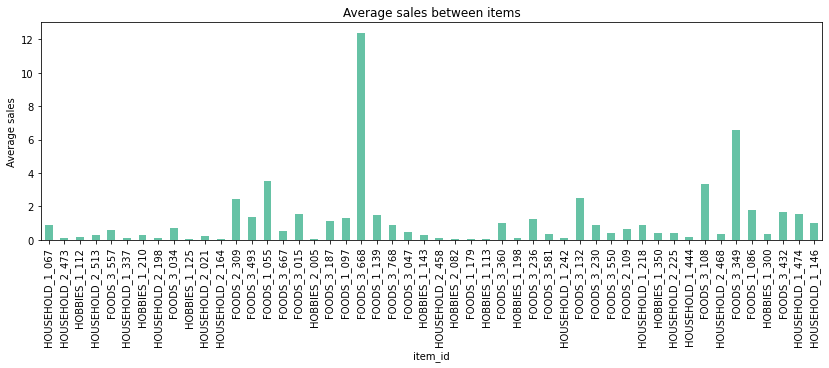

In [364]:
daily_sale_by_rand_store, _ = getDailySaleByStore()

f, ax = plt.subplots(figsize=(14, 4))
daily_sale_by_rand_store.groupby('item_id')['sold'].mean().sample(50).plot(kind='bar')
ax.set_title('Average sales between items')
ax.set_ylabel('Average sales')


- It’s clear that the sales between different items are different, which is in line with our common sense

## 4.2 Distribution of total sales by category


[Text(0.5, 1.0, 'Total sales by category')]

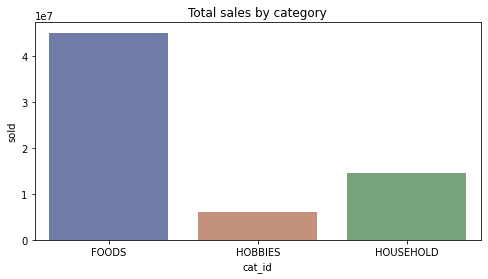

In [398]:
sales_group_by_cate = df.groupby(['cat_id'])['sold'].sum().reset_index()

fig, ax = plt.subplots( figsize=(8,4))
g = sns.barplot(
    data=sales_group_by_cate,
    x="cat_id", y="sold", 
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Total sales by category')


- Food category has the largest sales followed by household and hobbies on the whole.

## 4.2 Total Daily sales trend by category


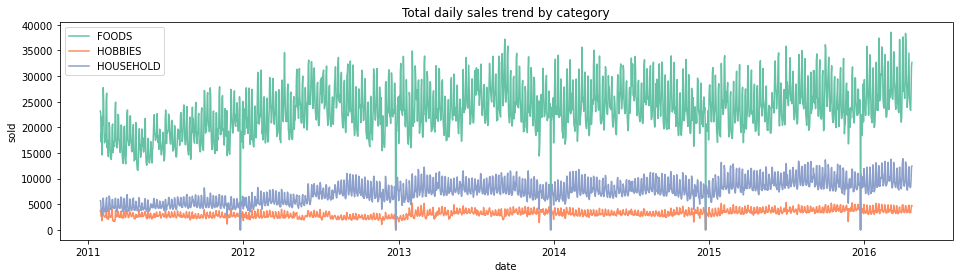

In [465]:
fig, ax = plt.subplots(figsize=(16, 4))
avg_sales_group_by_cate_daily = df.groupby(['cat_id', 'date'])['sold'].sum().reset_index()

gi = sns.lineplot(
    data=avg_sales_group_by_cate_daily,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Total daily sales trend by category')
gi.legend(loc="upper left")


- Food category has the highest sales than the others.
 
 
- It looks like the sales decrease a lot at the end of the year.
 
 
- The sales on ‘Hobbies’ don't change a lot over the years.


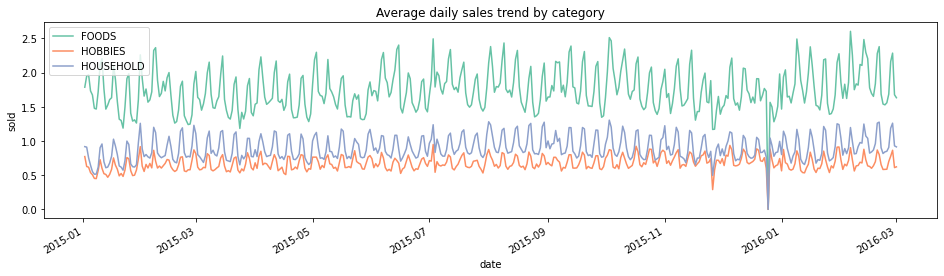

In [466]:
import matplotlib.dates as mdates

mask = (df['date'] > '2015-1-1') & (df['date'] <= '2016-3-1')
avg_sales_group_by_cate_year_month = df.loc[mask].groupby(['cat_id', 'date'])['sold'].mean().reset_index()


fig, ax = plt.subplots(figsize=(16, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_year_month,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Average daily sales trend by category')
gi.legend(loc="upper left")

# set ticks every week
# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate() # Rotation


### Christmas Day

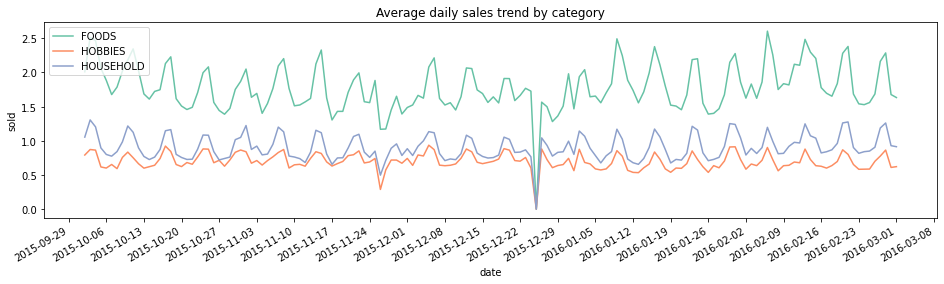

In [464]:
import matplotlib.dates as mdates

mask = (df['date'] > '2015-10-1') & (df['date'] <= '2016-3-1')
avg_sales_group_by_cate_year_month = df.loc[mask].groupby(['cat_id', 'date'])['sold'].mean().reset_index()


fig, ax = plt.subplots(figsize=(16, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_year_month,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Average daily sales trend by category')
gi.legend(loc="upper left")

# set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gcf().autofmt_xdate() # Rotation


- There is some weekly pattern.


- The sales before Christmas don’t increase much as we expect. On the contrary, more items are sold after Christmas, especially during the following 2 weeks.


- Do other holidays have the same pattern?



In [497]:
df["week"] = df["date"].dt.week.astype("int8")

df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week
0,FOODS_3_035_WI_1_validation,FOODS_3_035,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
1,FOODS_3_519_CA_4_validation,FOODS_3_519,FOODS_3,FOODS,CA_4,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
2,FOODS_3_545_CA_3_validation,FOODS_3_545,FOODS_3,FOODS,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
3,HOUSEHOLD_1_314_TX_3_validation,HOUSEHOLD_1_314,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4
4,HOBBIES_1_214_CA_3_validation,HOBBIES_1_214,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4


## 4.3 Distribution of  average monthly sales by category


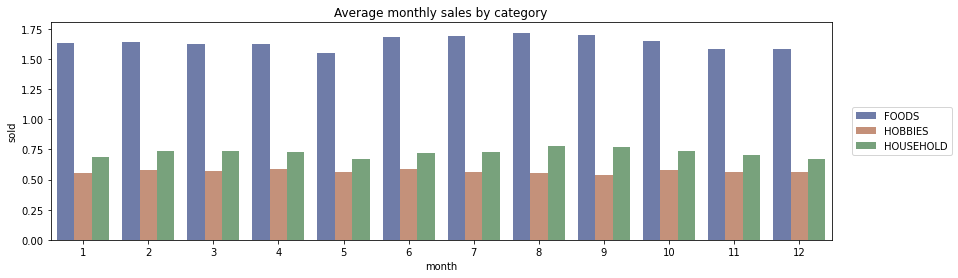

In [429]:
avg_sales_group_by_cate_month = df.groupby(['month', 'cat_id'])['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14,4))
g = sns.barplot(
    data=avg_sales_group_by_cate_month,
    x="month", y="sold", hue="cat_id",
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Average monthly sales by category')
g.legend(loc='center right', bbox_to_anchor=(1.16, 0.5), ncol=1)


- Food category has the largest sales across all the months, followed by hobbies and household.

- The average sales are more or less constant between 12 months.


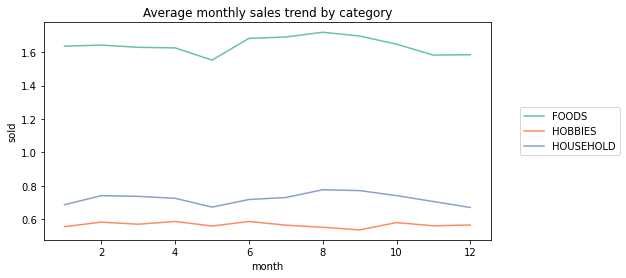

In [433]:
fig, ax = plt.subplots(figsize=(8, 4))
avg_sales_group_by_cate_daily = df.groupby(['cat_id', 'month'])['sold'].mean().reset_index()

gi = sns.lineplot(
    data=avg_sales_group_by_cate_daily,
    x="month", y="sold", 
    hue='cat_id'
)
gi.set(title='Average monthly sales trend by category')
gi.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)


- There is a decrease from January to the end of April, after that, the sales increase until the end of September.


- Therefore, sales are larger in summer than winter.



## 4.4 Distribution of average weekday  sales by category


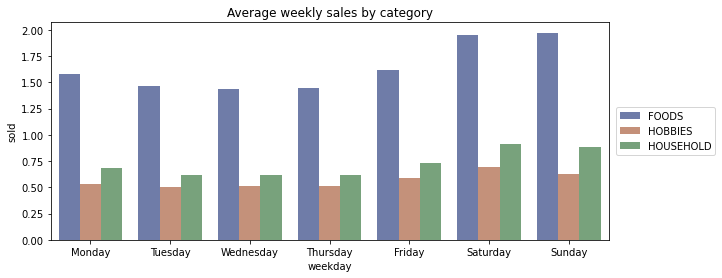

In [428]:

avg_sales_group_by_cate_weekday = df.groupby(['weekday', 'cat_id'])['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,4))

g = sns.barplot(
    data=avg_sales_group_by_cate_weekday,
    x='weekday', y="sold", hue="cat_id",
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Average weekly sales by category')
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)


- There are more sales on Saturday and Sunday.

- Therea are fewer sale on Wednesday and Thurday.


<ipython-input-616-fd2d7fb39360>:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

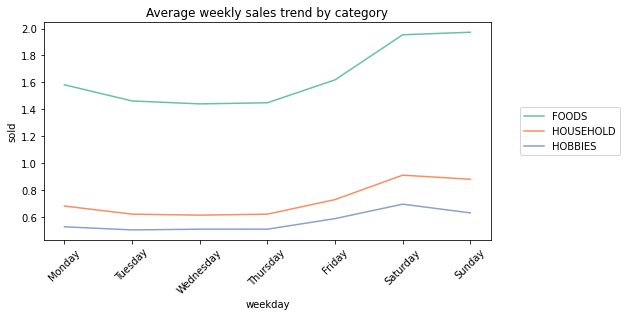

In [616]:
from pandas.api.types import CategoricalDtype

avg_sales_group_by_cate_weekly = df.groupby(['cat_id', 'weekday'])['sold'].mean().reset_index()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
avg_sales_group_by_cate_weekly['weekday'] = avg_sales_group_by_cate_weekly['weekday'].astype(cat_type)
avg_sales_group_by_cate_weekly = avg_sales_group_by_cate_weekly.sort_values('weekday')
avg_sales_group_by_cate_weekly.head()

fig, ax = plt.subplots(figsize=(8, 4))
gi = sns.lineplot(
    data=avg_sales_group_by_cate_weekly,
    x="weekday", y="sold", 
    sort=False,
    hue='cat_id'
)
gi.set(title='Average weekly sales trend by category')
gi.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
gi.set_xticklabels(g.get_xticklabels(), rotation=45)

There are more sales on Saturday and Sunday.

There are fewer sales on Wednesday and Thursday.


## 4.5 Sales trend of a single item

In [35]:
# randomly pick an item to look at its daily sale
item_daily_sale, item_id = getDailySaleByItem('HOBBIES_1_001')

# check
item_daily_sale[item_daily_sale['store_id'] == 'CA_1']


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
9096,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
39586,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
70076,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
100566,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
131056,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0
...,...,...,...,...,...,...,...,...
58184016,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1909,1
58214506,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1910,3
58244996,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1911,0
58275486,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1912,1


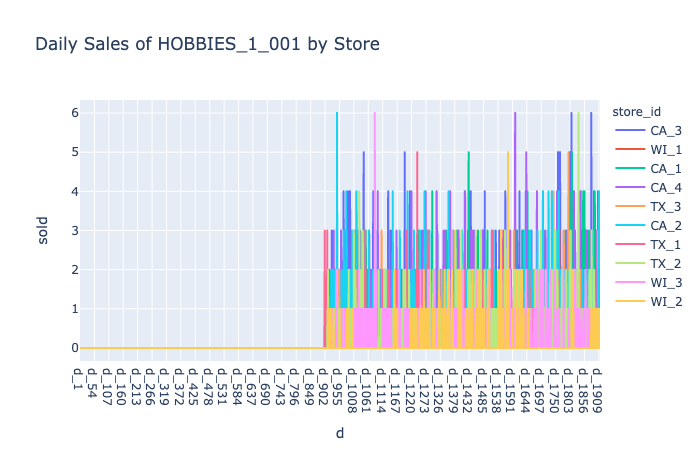

/Users/wuxiaopan/work/GroupWork/AML/HelperFunctions.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



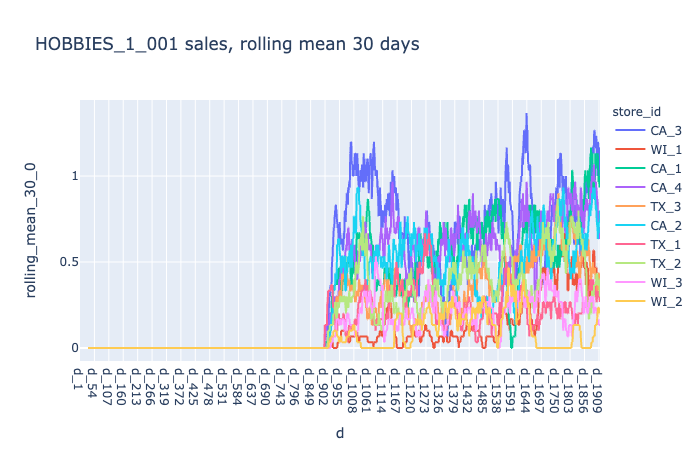

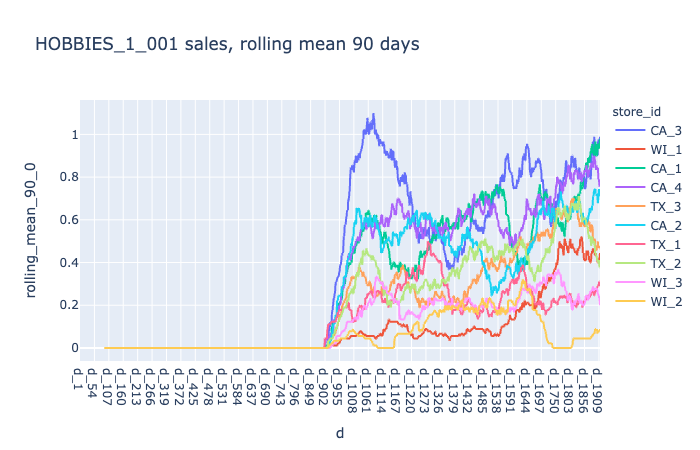

In [36]:
fig = px.line(
    item_daily_sale, 
    x=time_unit, y='sold', color='store_id', 
    title='Daily Sales of ' + item_id + ' by Store')

fig.show()

# rolling
window_size = [30, 90]
shift=0
for s in window_size:
    item_daily_sale_rolling = hf.rollingMeanDemandFeature(item_daily_sale, s, shift)
    fig = px.line(
        item_daily_sale_rolling, 
        x=time_unit, y='rolling_mean_' + str(s)+'_'+str(shift), color='store_id', 
        title=item_id + ' sales, rolling mean ' + str(s) + ' days')
    fig.show()



### Sale Trend Summary

- Some items don't have sales until some day(e.g. d_900)


- The sale pattern is clear in seasonal sales.


- Sales are very low.


## 4.5 Sales distribution of a single item

In [287]:
# fig = px.histogram(
#     item_daily_sale, 
#     x="sold", color='store_id',   
#     width=320, height=320, title='Daily Sales of ' + item_id + ' by Store'
# )
# fig.show()

# fig = px.box(
#     item_daily_sale, 
#     x="store_id", y="sold", 
#     width=320, height=320,
#     title='Daily Sales of ' + item_id + ' by Store')
# fig.show()


# # total
# fig = make_subplots(rows=1, cols=2)
# fig.add_trace(
#     go.Line(x=item_daily_sale[time_unit], y=item_daily_sale['sold']),
#     row=1, col=1
# )
# fig.add_trace(
#     go.Histogram(x=item_daily_sale["sold"]),
#     row=1, col=2
# )

# fig.update_layout(showlegend=False, title_text='Total Daily Sales of ' + item_id)
# fig.show()


# 5. Sales by Store


## 5.1 Total sales between all the stores

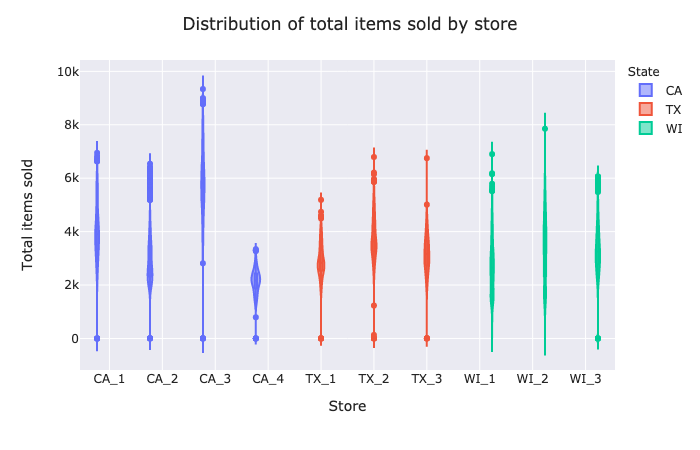

In [39]:
group = df.groupby(['d', 'state_id', 'store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold', box=True)


fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of total items sold by store', legend_title_text='State')
fig.show()


- Different stores have different sales, and ‘CA_3' has the highest sales while 'CA_4' has the smallest among all the stores. So the sales are somehow related to the store.



## 5.2 Total sales by Category between all the stores

In [328]:
sales_group_by_store_cate = df.groupby(['store_id', 'cat_id'])['sold'].sum().reset_index()


[Text(0.5, 1.0, 'Total sales by store')]

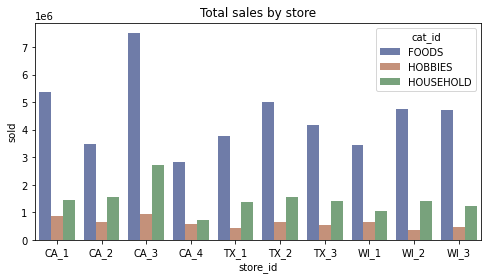

In [399]:
fig, ax = plt.subplots(figsize=(8,4))

g = sns.barplot(
    data=sales_group_by_store_cate,
    x="store_id", y="sold", hue="cat_id",
    ci="sd", palette="dark", alpha=.6, 
)
g.set(title='Total sales by store')


- Food has the largest sales followed by household and hobbies across all the stores.


- Hobbies category seems to have small changes between the three stores while the other two change a lot.


## 5.3 Total Daily Sales Trend by Category between all the stores

In [366]:
sale_by_date_cat_store = df.groupby(['store_id', 'cat_id', 'date'])['sold'].sum().reset_index()

sale_by_date_cat_store.head()


,store_id,cat_id,date,sold
0,CA_1,FOODS,2011-01-29,3239
1,CA_1,FOODS,2011-01-30,3137
2,CA_1,FOODS,2011-01-31,2008
3,CA_1,FOODS,2011-02-01,2258
4,CA_1,FOODS,2011-02-02,2032


<ipython-input-467-5aa2b14742fd>:20: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



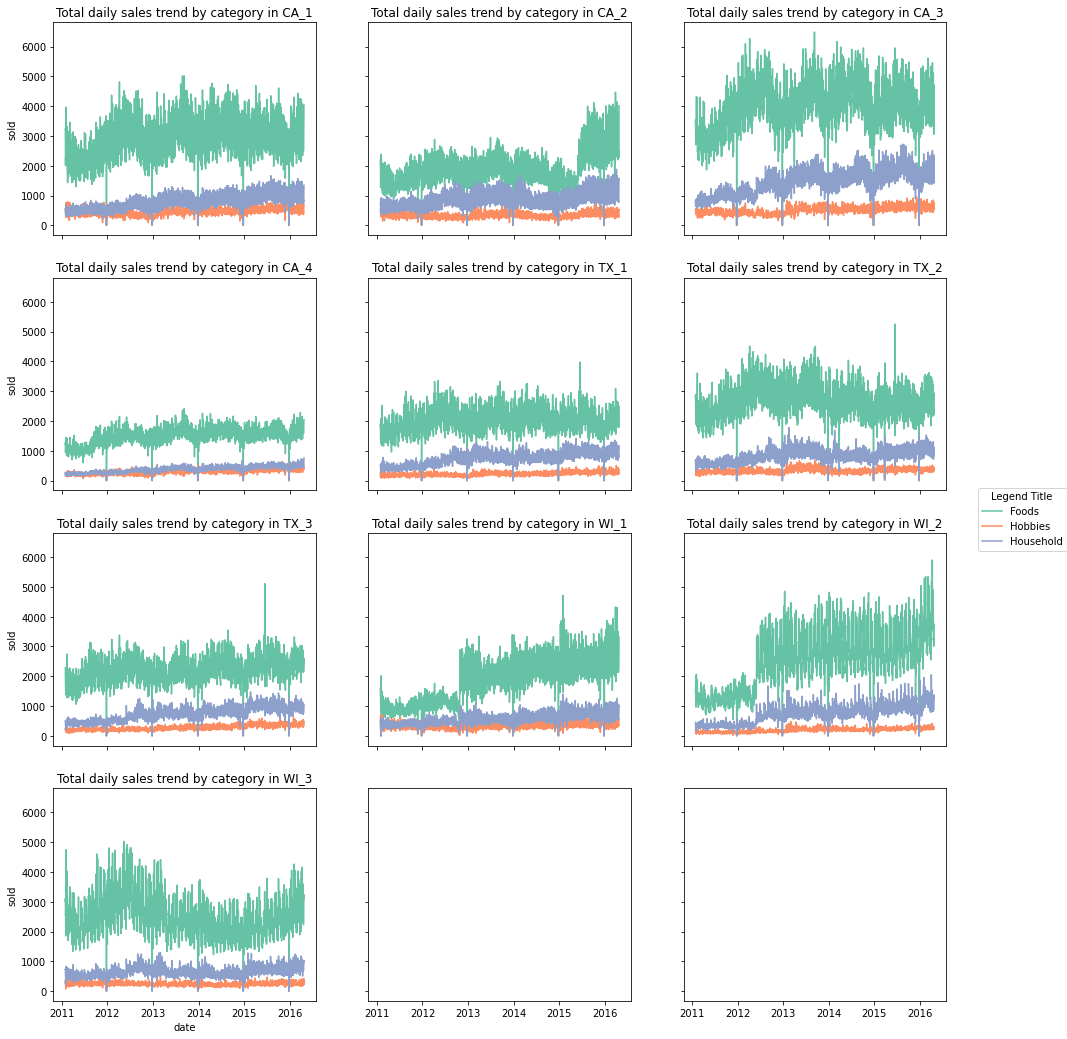

In [467]:
fig, ax = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(16, 18))
stores = df_sales['store_id'].unique()
g=[]
line_labels = ['Foods', 'Hobbies', 'Household']

for (i, s) in enumerate(stores):
    store_sales = sale_by_date_cat_store.loc[sale_by_date_cat_store['store_id'] == s]
    gi = sns.lineplot(
        data=store_sales,
        x="date", y="sold", 
        hue='cat_id', 
        ax=ax[i//3, i%3]
    )
    gi.set(title='Total daily sales trend by category in ' + s)
    g.append(gi)

for gi in g:
    gi.get_legend().remove()

fig.legend(g, 
    labels=line_labels, 
    loc="center right", 
    borderaxespad=0.1, 
    title="Legend Title"
)


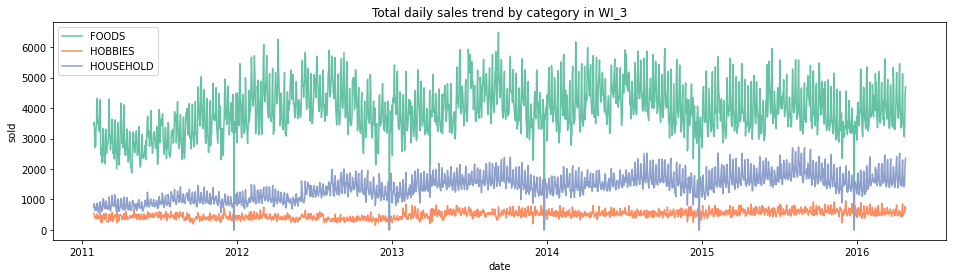

In [468]:
fig, ax = plt.subplots(figsize=(16, 4))
stores = df_sales['store_id'].unique()

one_store_sales = sale_by_date_cat_store.loc[sale_by_date_cat_store['store_id'] == np.random.choice(stores)]
gi = sns.lineplot(
    data=one_store_sales,
    x="date", y="sold", 
    hue='cat_id'
)
gi.set(title='Total daily sales trend by category in ' + s)
gi.legend(loc="upper left")


- It looks like the sales decrease a lot at the end of the year.


## 5.4 Average Monthly Sales Trend by Category between all the stores

In [477]:
sale_by_month_cat_store = df.groupby(['store_id', 'cat_id', 'month'])['sold'].mean().reset_index()

sale_by_month_cat_store.head()


,store_id,cat_id,month,sold
0,CA_1,FOODS,1,1.890524
1,CA_1,FOODS,2,1.889877
2,CA_1,FOODS,3,1.910125
3,CA_1,FOODS,4,1.969373
4,CA_1,FOODS,5,1.940153


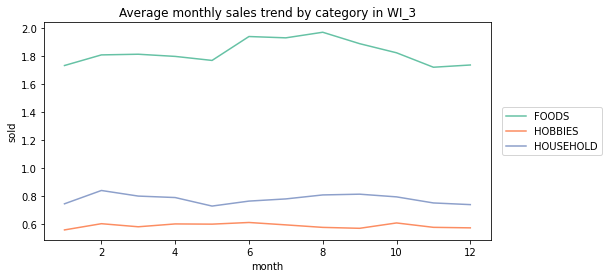

In [489]:
stores = df_sales['store_id'].unique()

one_store_month_sales = sale_by_month_cat_store.loc[sale_by_month_cat_store['store_id'] == np.random.choice(stores)]

fig, ax = plt.subplots(figsize=(8, 4))
gi = sns.lineplot(
    data=one_store_month_sales,
    x="month", y="sold", 
    hue='cat_id'
)
gi.set(title='Average monthly sales trend by category in ' + s)
gi.legend(loc='center right', bbox_to_anchor=(1.26, 0.5), ncol=1)

## 5.5 Average weekday sales trend by category between the stores



<ipython-input-492-ee1460d2517c>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



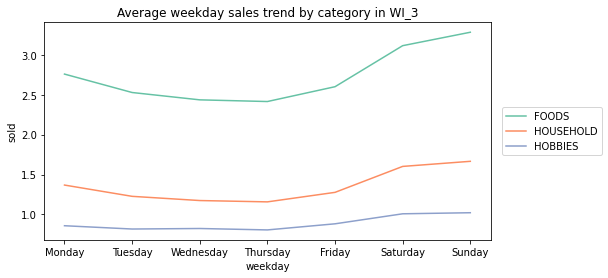

In [492]:
from pandas.api.types import CategoricalDtype

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sale_by_weekday_cat_store = df.groupby(['store_id', 'cat_id', 'weekday'])['sold'].mean().reset_index()

stores = df_sales['store_id'].unique()
one_store_weekday_sales = sale_by_weekday_cat_store.loc[sale_by_weekday_cat_store['store_id'] == np.random.choice(stores)]

cat_type = CategoricalDtype(categories=cats, ordered=True)
one_store_weekday_sales['weekday'] = one_store_weekday_sales['weekday'].astype(cat_type)
one_store_weekday_sales = one_store_weekday_sales.sort_values('weekday')



fig, ax = plt.subplots(figsize=(8, 4))
gi = sns.lineplot(
    data=one_store_weekday_sales,
    x="weekday", y="sold", 
    hue='cat_id'
)
gi.set(title='Average weekday sales trend by category in ' + s)
gi.legend(loc='center right', bbox_to_anchor=(1.26, 0.5), ncol=1)



# 6. Sale vs Snap




<AxesSubplot:xlabel='snap_WI', ylabel='count'>

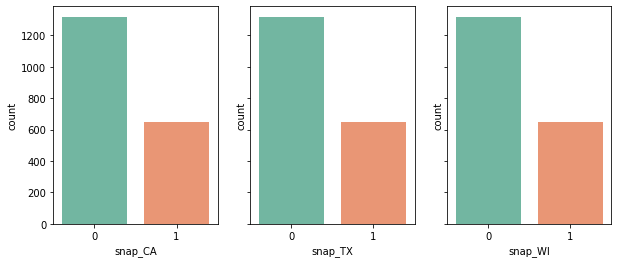

In [582]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

sns.countplot(x="snap_CA", data=calendar, ax=axs[0])
sns.countplot(x="snap_TX", data=calendar, ax=axs[1])
sns.countplot(x="snap_WI", data=calendar, ax=axs[2])
# fig.set(title='ds')

- The distributions of snap are similar between the three stores.


- One third of the total days are days that is allowd to use vourcher.


[Text(0.5, 1.0, 'Distribution of snap_WI by year')]

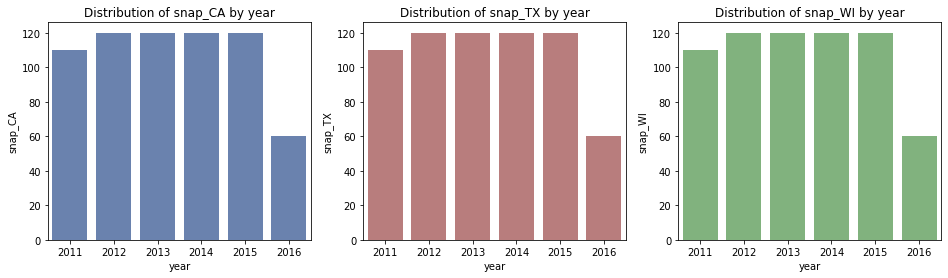

In [588]:

year_snap = calendar.groupby(['year'])[['snap_CA', 'snap_TX', 'snap_WI']].sum().reset_index()

fig, ax = plt.subplots(1, 3, figsize=(16,4))

sns.set_color_codes("muted")
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_CA",
    color="b", saturation=.5,
    ax=ax[0]
)
g.set(title='Distribution of snap_CA by year')
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_TX",
    color="r", saturation=.5,
    ax=ax[1]
)
g.set(title='Distribution of snap_TX by year')
g = sns.barplot(
    data=year_snap,
    x="year", y="snap_WI",
    color="g", saturation=.5,
    ax=ax[2]
)
g.set(title='Distribution of snap_WI by year')




[Text(0.5, 1.0, 'Distribution of snap_WI by month, 2011')]

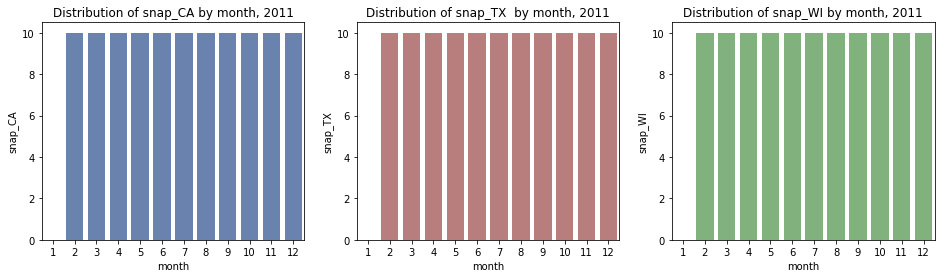

In [606]:

year_month_snap = calendar.groupby(['year', 'month'])[['snap_CA', 'snap_TX', 'snap_WI']].sum().reset_index()
rand_year = np.random.choice(calendar['year'].unique())
year_month_snap = year_month_snap[year_month_snap['year'] == rand_year]

fig, ax = plt.subplots(1, 3, figsize=(16,4))
sns.set_color_codes("muted")
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_CA",
    color="b", saturation=.5,
    ax=ax[0]
)
g.set(title='Distribution of snap_CA by month, ' + str(rand_year))
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_TX",
    color="r", saturation=.5,
    ax=ax[1]
)
g.set(title='Distribution of snap_TX  by month, ' + str(rand_year))
g = sns.barplot(
    data=year_month_snap,
    x="month", y="snap_WI",
    color="g", saturation=.5,
    ax=ax[2]
)
g.set(title='Distribution of snap_WI by month, ' + str(rand_year))



- There are 10 days that vouchers are allowed every month in each state


In [696]:
# fig, ax = plt.subplots(4, 3, figsize=(16, 16))
# year = 2011
# for i in range(12):
#     if i == 11:
#         a = str(i + 1)
#         b = '1'
#         next_year = year + 1
#     else:
#         a = str(i + 1)
#         b = str(i + 2)
#         next_year = year
#     mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(next_year)+'-' + b + '-1')
#     snap_year = calendar.loc[mask]
# #     print(snap_year[snap_year['snap_CA'] == 1]['date'])
#     sns.scatterplot(data=snap_year, x="date", y="snap_CA", ax=ax[i//3, i%3])
#     plt.gcf().autofmt_xdate() # Rotation


- The distribution of the days that vouchers are allowed to share the same pattern every month for every state.


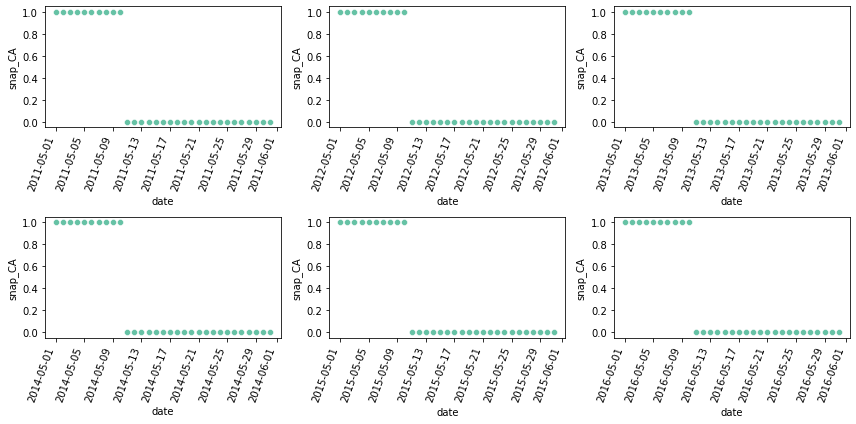

In [690]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_CA", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


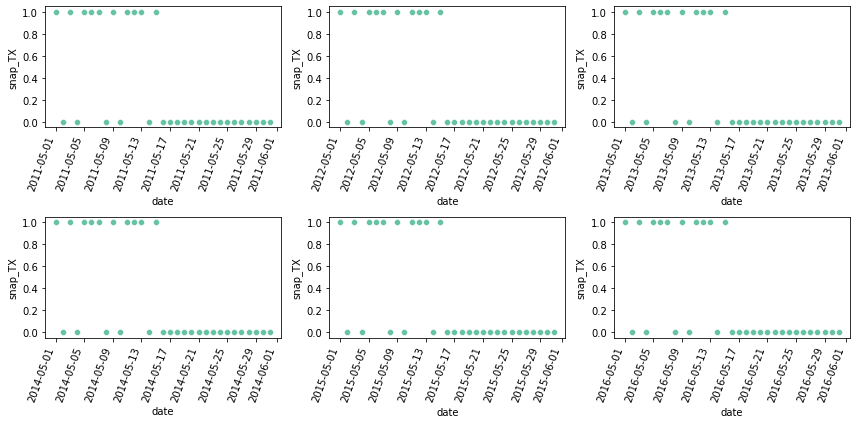

In [691]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_TX", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


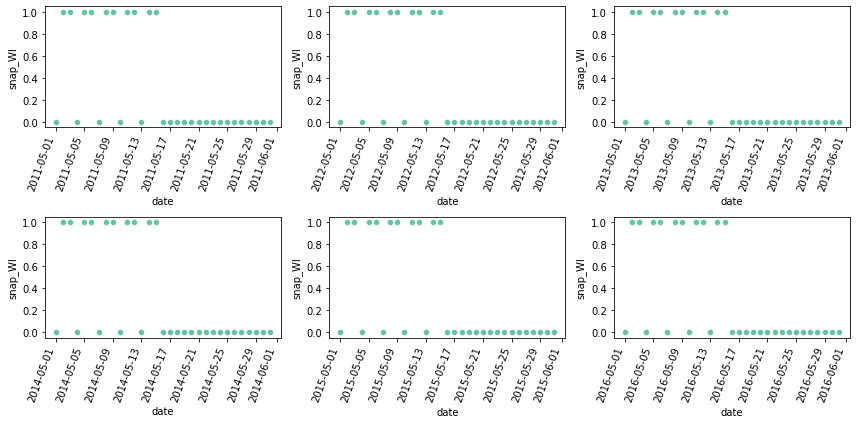

In [692]:
fig, ax = plt.subplots(2, 3,figsize=(12, 6), sharex=False)
year_list = calendar['year'].unique()

for i, year in enumerate(year_list):
    a = '5'
    b = '6'
    mask = (calendar['date'] >= str(year)+'-' + a + '-1') & (calendar['date'] < str(year)+'-' + b + '-1')
    snap_year = calendar.loc[mask]
    ax_i = ax[i//3, i%3]
    g = sns.scatterplot(data=snap_year, x="date", y="snap_WI", ax=ax_i)
    plt.setp(ax_i.get_xticklabels(), rotation=70, horizontalalignment='right')

fig.tight_layout()


## Do the sales increase on the Snap day?


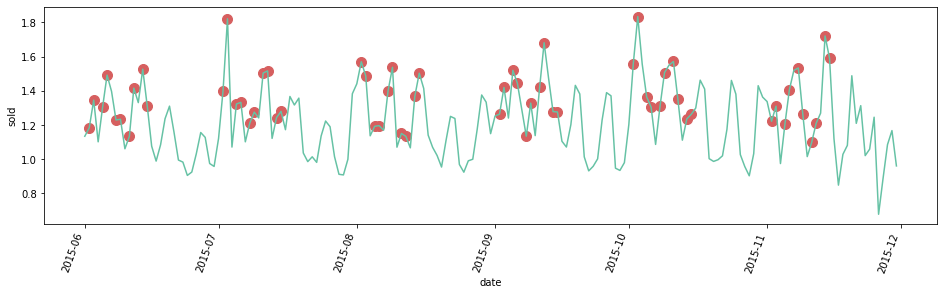

In [836]:
year = 2015
am = '6'
bm = '12'
state_id = 'WI'
mask = (df['date'] >= str(year)+'-' + am + '-1') & (df['date'] < str(year)+'-' + bm + '-1')

sale_rand_year = df.loc[mask]
sale_rand_year = sale_rand_year[sale_rand_year['state_id'] == state_id]
sale_rand_year_date = sale_rand_year.groupby('date')['sold'].mean().reset_index()

fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(data=sale_rand_year_date, x='date', y='sold', ax=ax)
mask_s = sale_rand_year.groupby('date')['snap_' + state_id].mean()
for i, snaped in enumerate(pd.DataFrame(mask_s)['snap_' + state_id]):
    if snaped == 1:
        ax.scatter(x=sale_rand_year_date.iloc[i]['date'], y=sale_rand_year_date.iloc[i]['sold'], c='r', s=100)
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.show()


# 7、Sales by Event
